In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = open('names.txt', 'r').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [ ]:
# build the vocabulary

chars = sorted(list(set(''.join(words))))
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0
itoc = {i:c for c,i in ctoi.items()}
vocab_size = len(itoc)
print(itoc)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def buld_the_dataset(words):
  X,Y = [],[]

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = ctoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = buld_the_dataset(words[:n1])
Xdev, Ydev = buld_the_dataset(words[n1:n2])
Xte, Yte = buld_the_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited

n_emb = 10 # the dimensionality of the character embeding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)   # for reproducibility
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((block_size * n_emb, n_hidden), generator=g) * (5/3)/((block_size * n_emb)**0.5) # kaiming
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# parameters = [C, W1, b1, W2, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # numner of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  #mini batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  #forward pass
  emb = C[Xtr[ix]] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concat the vector
  hpreact = embcat @ W1 #+ b1 # hidden layer preactivation
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / (bnstdi + 0.001) + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact) # nonlinearity, hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000: 3.3147


In [ ]:
logits.shape

torch.Size([32, 27])

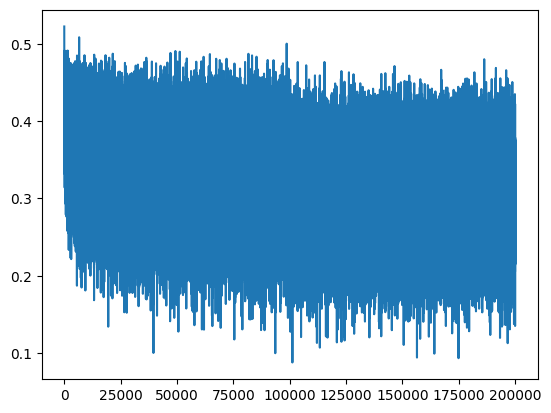

In [ ]:
plt.plot(lossi)

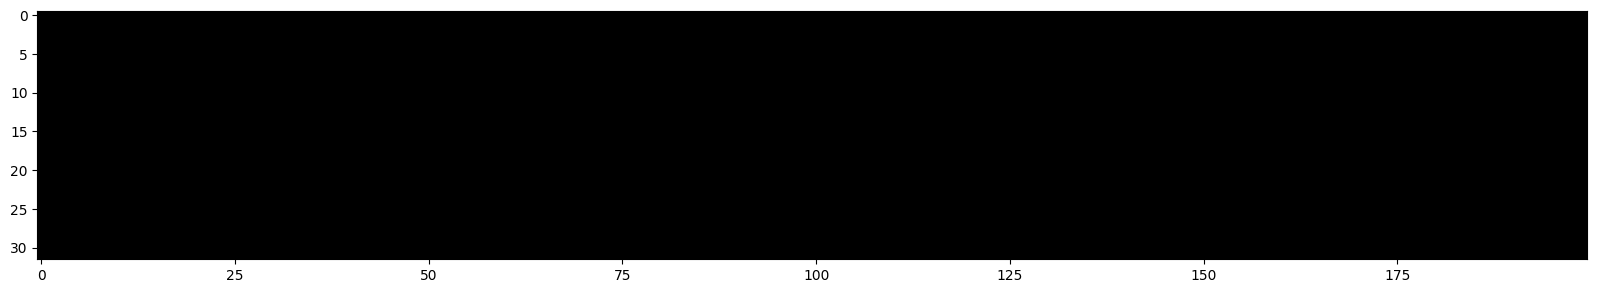

In [ ]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# if an entire column is white that maeans that is a dead neuron, and also your job is gone gone gone...

(array([  7.,  12.,  27.,  31.,  46.,  63.,  76.,  89., 100., 106., 125.,
        137., 162., 145., 161., 158., 172., 174., 167., 198., 176., 187.,
        201., 197., 195., 205., 187., 194., 205., 190., 180., 199., 159.,
        190., 155., 166., 176., 140., 154., 118., 121., 116., 112.,  91.,
         91.,  54.,  39.,  23.,  19.,   4.]),
 array([-0.96543849, -0.92657177, -0.88770505, -0.84883833, -0.80997161,
        -0.77110489, -0.73223817, -0.69337145, -0.65450473, -0.61563801,
        -0.5767713 , -0.53790458, -0.49903786, -0.46017114, -0.42130442,
        -0.3824377 , -0.34357098, -0.30470426, -0.26583754, -0.22697082,
        -0.1881041 , -0.14923739, -0.11037067, -0.07150395, -0.03263723,
         0.00622949,  0.04509621,  0.08396293,  0.12282965,  0.16169637,
         0.20056309,  0.2394298 ,  0.27829652,  0.31716324,  0.35602996,
         0.39489668,  0.4337634 ,  0.47263012,  0.51149684,  0.55036356,
         0.58923028,  0.62809699,  0.66696371,  0.70583043,  0.74469715,
 

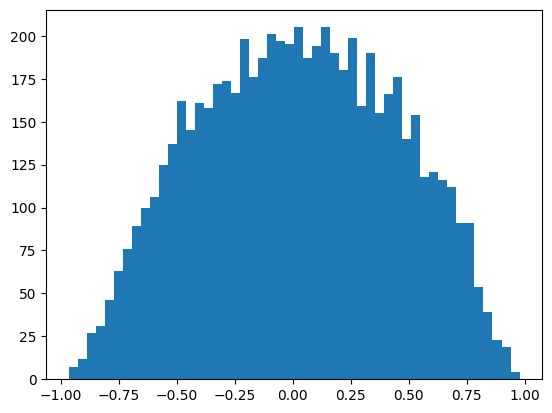

In [ ]:
plt.hist(h.view(-1).tolist(), 50)

(array([  3.,   0.,   3.,   0.,   1.,   3.,   6.,  17.,  13.,  18.,  34.,
         40.,  68.,  94., 114., 150., 190., 275., 277., 315., 349., 395.,
        419., 456., 395., 445., 384., 344., 304., 277., 234., 167., 166.,
        125.,  94.,  84.,  47.,  21.,  28.,  17.,   5.,   7.,   5.,   7.,
          3.,   0.,   0.,   0.,   0.,   1.]),
 array([-2.02036476, -1.9350165 , -1.84966825, -1.76431999, -1.67897173,
        -1.59362347, -1.50827521, -1.42292696, -1.3375787 , -1.25223044,
        -1.16688218, -1.08153392, -0.99618567, -0.91083741, -0.82548915,
        -0.74014089, -0.65479263, -0.56944438, -0.48409612, -0.39874786,
        -0.3133996 , -0.22805134, -0.14270308, -0.05735483,  0.02799343,
         0.11334169,  0.19868995,  0.28403821,  0.36938646,  0.45473472,
         0.54008298,  0.62543124,  0.7107795 ,  0.79612775,  0.88147601,
         0.96682427,  1.05217253,  1.13752079,  1.22286904,  1.3082173 ,
         1.39356556,  1.47891382,  1.56426208,  1.64961033,  1.73495859,
 

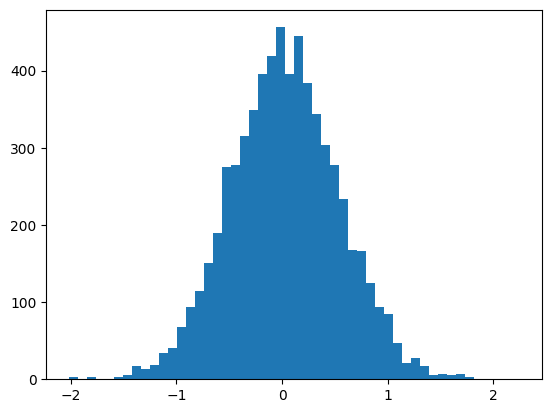

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50)

# as we can see hpreact is very very broad thus in h tanh is vary vary active

In [ ]:
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0664284229278564
val 2.1050145626068115


In [ ]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # forward pass
    emb = C[torch.tensor([context])] # (1,block_size,n_embd)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the window
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itoc[i] for i in out))

mora.
kmyanniell.
nihayla.
rethrelendraegradelynnelin.
shi.
jenrekeises.
anaraelyziollyan.
noshibvr.
shiriel.
kindreth.
konnie.
con.
brey.
der.
yarue.
els.
kaysh.
stella.
hil.
salynn.
